In [ ]:
pip install simpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


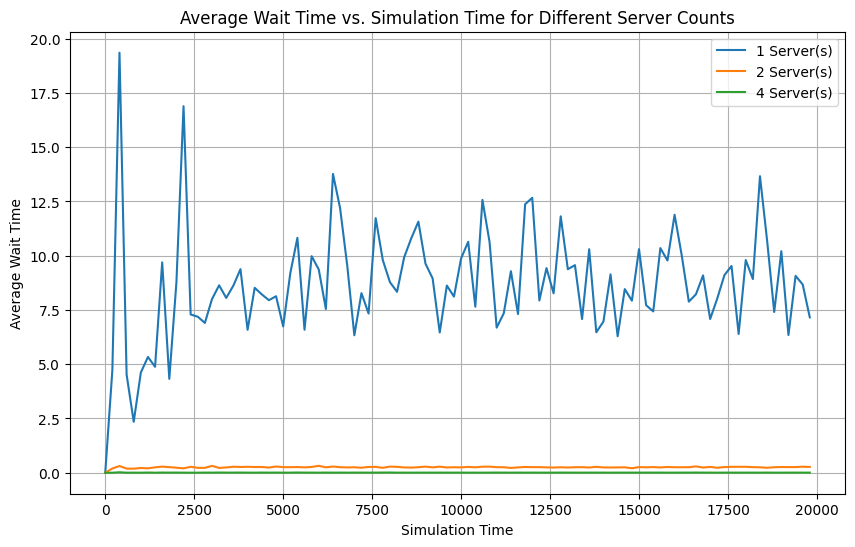

In [ ]:
import simpy
import random
import statistics

# Parameters
λ = 0.9  # Arrival rate
μ = 1   # Service rate of each server
servers = [1, 2, 4]  # Number of servers to simulate
# sim_time = 10000  # Simulation time

def customer(env, name, counter):
    """Customer process. Each customer arrives, waits, and is then served."""
    arrival_time = env.now
    with counter.request() as req:
        yield req
        wait = env.now - arrival_time
        wait_times.append(wait)
        service_time = random.expovariate(μ)
        yield env.timeout(service_time)

def setup(env, n):
    """Sets up the simulation environment with n servers."""
    counter = simpy.Resource(env, capacity=n)
    while True:
        yield env.timeout(random.expovariate(λ))
        env.process(customer(env, f'Customer{env.now}', counter))

average_wait_times = {n: [] for n in servers}  # Average waiting times for each number of servers
time_intervals = list(range(1, 20001, 200))  # Simulation time intervals from 1 to 20000, with a step of 200

for n in servers:
    random.seed(42)  # For reproducible results
    for sim_time in time_intervals:
        wait_times = []
        env = simpy.Environment()
        env.process(setup(env, n))
        env.run(until=sim_time)
        if wait_times:
            average_wait = statistics.mean(wait_times)
        else:
            average_wait = 0  # Set average wait to 0 if no data is available
        average_wait_times[n].append(average_wait)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for n in servers:
    plt.plot(time_intervals, average_wait_times[n], label=f'{n} Server(s)')

plt.xlabel('Simulation Time')
plt.ylabel('Average Wait Time')
plt.title('Average Wait Time vs. Simulation Time for Different Server Counts')
plt.legend()
plt.grid(True)
plt.show()

The statistical significance can be increased by running the simulation for a longer time or by executing multiple runs and averaging the results.
As for how the number of measurements required depends on ρ: When ρ is close to 1 (high system load), more measurements are needed to achieve high statistical significance due to increased variability in the system. Conversely, when ρ is lower, fewer measurements might suffice.

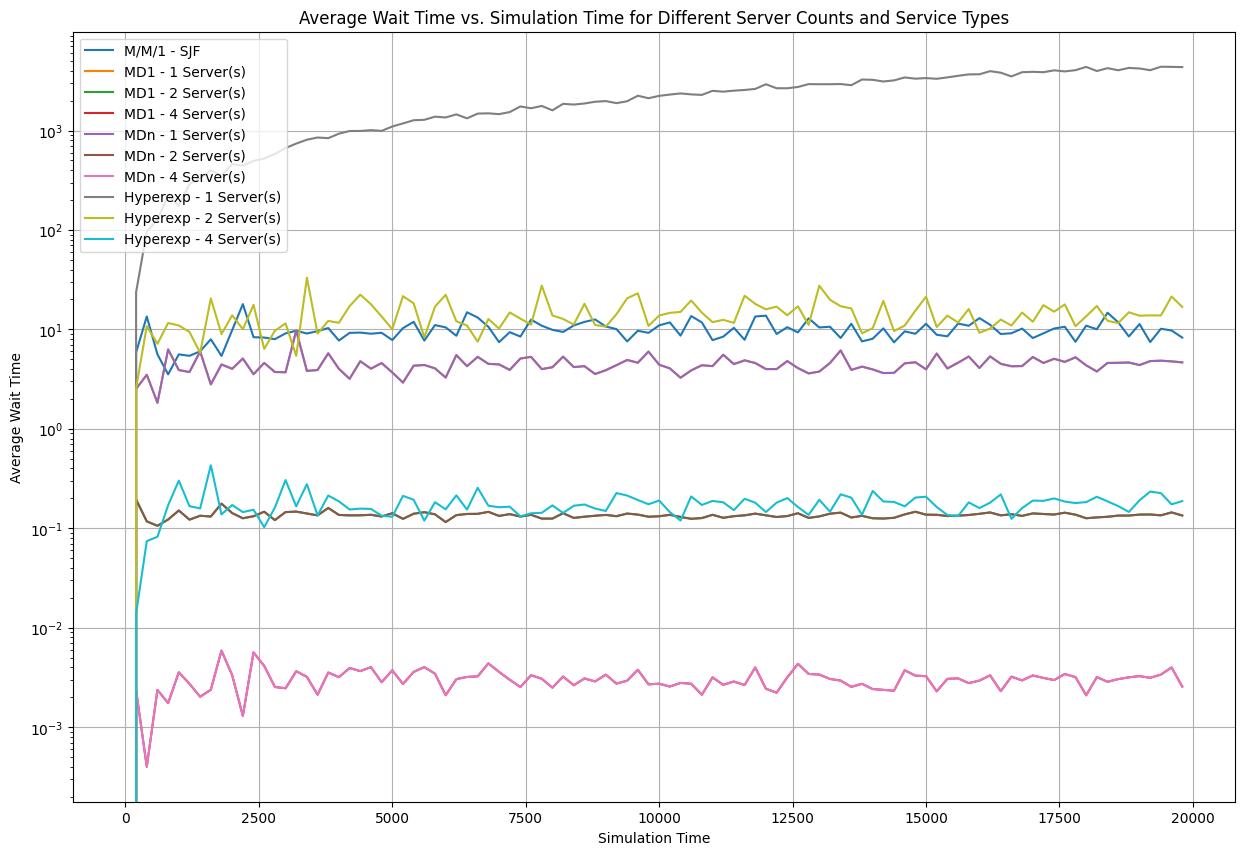

In [ ]:
import simpy
import random
import statistics
import matplotlib.pyplot as plt

def sjf_customer(env, name, server, arrival_time):
    with server.request(priority=env.now - arrival_time) as req:
        yield req
        service_time = random.expovariate(μ)
        yield env.timeout(service_time)
        wait = env.now - arrival_time - service_time
        wait_times.append(wait)

def sjf_setup(env, service_type):
    server = simpy.PriorityResource(env, capacity=1)
    while True:
        arrival_time = env.now
        yield env.timeout(random.expovariate(λ))
        env.process(sjf_customer(env, f'sjf_customer{arrival_time}', server, arrival_time))

λ = 0.9  # Arrival rate
μ = 1    # Service rate of the server

time_intervals = list(range(1, 20001, 200))  # Simulation time intervals
average_wait_times_sjf = []

random.seed(42)
for sim_time in time_intervals:
    wait_times = []
    env = simpy.Environment()
    env.process(sjf_setup(env, "M/M/1"))
    env.run(until=sim_time)
    average_wait = statistics.mean(wait_times) if wait_times else 0
    average_wait_times_sjf.append(average_wait)

# Plotting
plt.figure(figsize=(15, 10))
plt.plot(time_intervals, average_wait_times_sjf, label='M/M/1 - SJF')

# Replotting original data for comparison
for service_type in service_types:
    for n in servers:
        plt.semilogy(time_intervals, average_wait_times[service_type][n], label=f'{service_type} - {n} Server(s)')

plt.xlabel('Simulation Time')
plt.ylabel('Average Wait Time')
plt.title('Average Wait Time vs. Simulation Time for Different Server Counts and Service Types')
# plt.ylim(1e-4, 1e3)
plt.legend()
plt.grid(True)
plt.show()


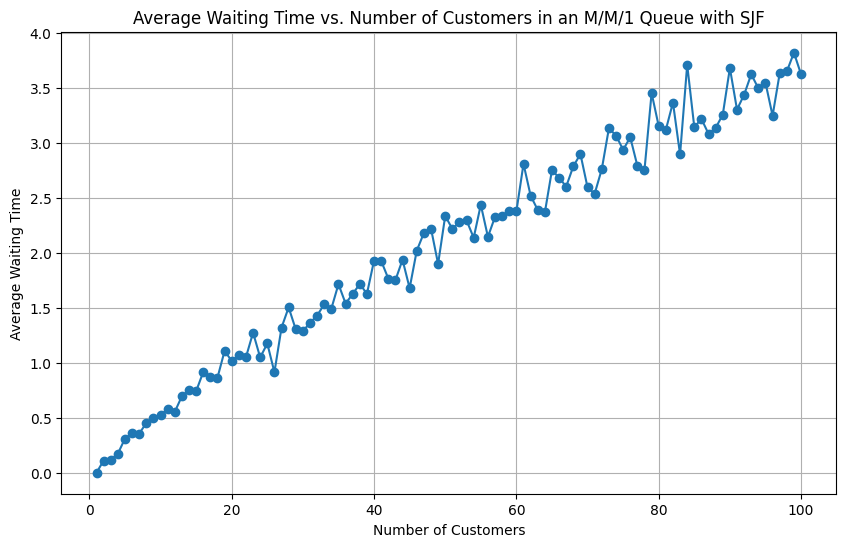

(3.624725570122601, 0.3502339961944325)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def MM1_SJF(lam, mu, num_customers, num_simulations):
    waiting_times = []

    for _ in range(num_simulations):
        # Generate interarrival and service times
        interarrival_times = np.random.exponential(1/lam, num_customers)
        service_times = np.random.exponential(1/mu, num_customers)

        # Sort jobs by service time for Shortest Job First
        sorted_indices = np.argsort(service_times)
        service_times = service_times[sorted_indices]

        # Initialize times
        arrival_times = np.cumsum(interarrival_times)
        service_start_times = np.zeros(num_customers)
        service_end_times = np.zeros(num_customers)

        for i in range(num_customers):
            if i == 0:
                service_start_times[i] = arrival_times[i]
            else:
                service_start_times[i] = max(arrival_times[i], service_end_times[i-1])
            service_end_times[i] = service_start_times[i] + service_times[i]

        # Calculate waiting times
        waiting_times.append(np.mean(service_start_times - arrival_times))

    # Calculate average wait time and confidence diameter
    average_waiting_time = np.mean(waiting_times)
    std_deviation = np.std(waiting_times)
    confidence_diameter = 1.96 * std_deviation / np.sqrt(num_simulations)

    return average_waiting_time, confidence_diameter

# Adjusted simulation parameters
lambda_rate = 0.9      # Arrival rate
mu_rate = 1.0          # Service rate
max_customers = 100    # Maximum number of customers to simulate (reduced)
num_simulations = 50   # Number of simulations (reduced)

# Simulating for different customer numbers
average_waiting_times = []
confidence_diameters = []

for num_customers in range(1, max_customers + 1):
    avg_time, conf_diameter = MM1_SJF(lambda_rate, mu_rate, num_customers, num_simulations)
    average_waiting_times.append(avg_time)
    confidence_diameters.append(conf_diameter)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_customers + 1), average_waiting_times, marker='o')
plt.xlabel('Number of Customers')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time vs. Number of Customers in an M/M/1 Queue with SJF')
plt.grid(True)
plt.show()

# Returning the last calculated values for example
average_waiting_times[-1], confidence_diameters[-1]
